### Importing libraries

In [ ]:
import random
import imageio
import time
import numpy as np
from argparse import ArgumentParser
from itertools import chain

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# import einops
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.data import Subset


from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import MNIST, FashionMNIST

### Hyper parameters

In [ ]:
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [ ]:
fashion = False
batch_size = 64
n_epochs = 50
lr = 3e-4
num_samples_generate = 16

### Preprocessing data

In [ ]:
transform = Compose([
    # ToTensor(),
    # Lambda(lambda x: (x - 0.5) * 2)],
    ToTensor(), # Scales data into [0,1]
    Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
])
ds_fn = FashionMNIST if fashion else MNIST
dataset = ds_fn("./datasets", download=True, train=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 6046830.87it/s]


Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 159967.48it/s]


Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1510387.33it/s]


Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4894791.56it/s]

Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



In [ ]:
loader = DataLoader(dataset, batch_size, shuffle=True)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### DDPM architecture

In [ ]:
class MyDDPM(nn.Module):
    def __init__(self, network, n_steps=300, min_beta=10 ** -4, max_beta=0.02, device=None, image_chw=(1, 28, 28)):
        super(MyDDPM, self).__init__()
        self.n_steps = n_steps
        self.device = device
        self.image_chw = image_chw
        self.network = network.to(device)
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(
            device)  # Number of steps is typically in the order of thousands
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)

    def forward(self, x0, t, eta=None):
        # Make input image more noisy (we can directly skip to the desired step)
        n, c, h, w = x0.shape
        a_bar = self.alpha_bars[t]

        if eta is None:
            eta = torch.randn(n, c, h, w).to(self.device)

        noisy = a_bar.sqrt().reshape(n, 1, 1, 1) * x0 + (1 - a_bar).sqrt().reshape(n, 1, 1, 1) * eta
        return noisy

    def backward(self, x, t):
        # Run each image through the network for each timestep t in the vector t.
        # The network returns its estimation of the noise that was added.
        return self.network(x, t)

### The forward process (one-step):

$q(x_t | x_0) = N(x_t; \sqrt{\bar{\alpha_t}}x_0 , (1 - \bar{\alpha_t})I)$

In [ ]:
def show_forward(ddpm, loader, device):
    for batch in loader:
        imgs = batch[0]

        show_images(imgs)

        for percent in [0.25, 0.5, 0.75, 1]:
            show_images(
                ddpm(imgs.to(device),
                     [int(percent * ddpm.n_steps) - 1 for _ in range(len(imgs))])
            )
        break

### Inference Step

$x_{t-1} = \frac{1}{\sqrt{\alpha_t}} (x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha_t}}} \epsilon_{\theta}(x_t, t) ) + \sigma_t z \; \; \; (t\in \{ 1, ..., T \}) \; \; \; z \sim N(0, I)$

In [ ]:
def show_images(images, save = False, show = True, epoch = -1, batch_size = -1, index = -1, forward = False):

    # path_to_save = "/content/gdrive/MyDrive/Generative_Output"

    # Convert Tensor to numpy
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()

    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    if show:
      fig = plt.figure(figsize=(5, 5))
      idx = 0
      for r in range(rows):
          for c in range(cols):
              fig.add_subplot(rows, cols, idx + 1)
              if idx < len(images):
                  plt.imshow(images[idx][0], cmap="gray")
                  plt.axis('off')
                  # if save:
                  #   image_name = path_to_save + '/'+str(epoch)+"_"+str(batch_size)+"_label_"+str(idx)+"_"+ str(index) +".png"
                  #   plt.savefig(image_name)
                  idx += 1
      plt.show()
      plt.close(fig)

In [ ]:
def inference_step(index, show, save):
    start = time.time()
    generated = generate_new_images(
            ddpm,
            n_samples = num_samples_generate,
            device = device
          )
    end = time.time()
    # print("Output shape: ", np.asarray(generated).shape)

    exe_time = end - start
    inference_exe_time.append(exe_time)

    if show:
      print("Execution time for ", n_epochs, " epochs and ", batch_size, " batch sizes: ", exe_time)
      show_images(generated, save, show, n_epochs, batch_size, index, forward = True)

In [ ]:
def generate_new_images(ddpm, n_samples= num_samples_generate, device=None, c=1, h=28, w=28):

    with torch.no_grad():
        if device is None:
            device = ddpm.device

        # Starting from random noise
        x = torch.randn(n_samples, c, h, w).to(device)

        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
            # Estimating noise to be removed
            time_tensor = (torch.ones(n_samples, 1) * t).to(device).long()
            eta_theta = ddpm.backward(x, time_tensor)

            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]

            # Partially denoising the image
            x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)

            if t > 0:
                z = torch.randn(n_samples, c, h, w).to(device)

                beta_t = ddpm.betas[t]
                sigma_t = beta_t.sqrt()

                x = x + sigma_t * z
    # Convert Tensor to numpy
    if type(x) is torch.Tensor:
        x = x.detach().cpu().numpy()

    global generated_images
    if len(generated_images) == 0:
      generated_images = x
    elif len(generated_images) > 0:
      generated_images = np.append(generated_images, x, axis = 1)

    return x

In [ ]:
class MyBlock(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(MyBlock, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        self.activation = nn.ReLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        return out

### Embedding time in the network

In [ ]:
def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = torch.zeros(n, d)
    wk = torch.tensor([1 / 10_000 ** (2 * j / d) for j in range(d)])
    wk = wk.reshape((1, d))
    t = torch.arange(n).reshape((n, 1))
    embedding[:,::2] = torch.sin(t * wk[:,::2])
    embedding[:,1::2] = torch.cos(t * wk[:,::2])

    return embedding

### The basic U-Net
This network recieves $x_t$ and returns $x_{t-1}$

In [ ]:
class MyUNet(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=100):
        super(MyUNet, self).__init__()

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        # First half
        self.te1 = self._make_te(time_emb_dim, 1)
        self.b1 = nn.Sequential(
            MyBlock((1, 28, 28), 1, 10),
            MyBlock((10, 28, 28), 10, 10),
            MyBlock((10, 28, 28), 10, 10)
        )
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1)

        self.te2 = self._make_te(time_emb_dim, 10)
        self.b2 = nn.Sequential(
            MyBlock((10, 14, 14), 10, 20),
            MyBlock((20, 14, 14), 20, 20),
            MyBlock((20, 14, 14), 20, 20)
        )
        self.down2 = nn.Conv2d(20, 20, 4, 2, 1)

        self.te3 = self._make_te(time_emb_dim, 20)
        self.b3 = nn.Sequential(
            MyBlock((20, 7, 7), 20, 40),
            MyBlock((40, 7, 7), 40, 40),
            MyBlock((40, 7, 7), 40, 40)
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(40, 40, 2, 1),
            nn.SiLU(),
            nn.Conv2d(40, 40, 4, 2, 1)
        )

        # Bottleneck
        self.te_mid = self._make_te(time_emb_dim, 40)
        self.b_mid = nn.Sequential(
            MyBlock((40, 3, 3), 40, 20),
            MyBlock((20, 3, 3), 20, 20),
            MyBlock((20, 3, 3), 20, 40)
        )

        # Second half
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(40, 40, 4, 2, 1),
            nn.SiLU(),
            nn.ConvTranspose2d(40, 40, 2, 1)
        )

        self.te4 = self._make_te(time_emb_dim, 80)
        self.b4 = nn.Sequential(
            MyBlock((80, 7, 7), 80, 40),
            MyBlock((40, 7, 7), 40, 20),
            MyBlock((20, 7, 7), 20, 20)
        )

        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.te5 = self._make_te(time_emb_dim, 40)
        self.b5 = nn.Sequential(
            MyBlock((40, 14, 14), 40, 20),
            MyBlock((20, 14, 14), 20, 10),
            MyBlock((10, 14, 14), 10, 10)
        )

        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, 20)
        self.b_out = nn.Sequential(
            MyBlock((20, 28, 28), 20, 10),
            MyBlock((10, 28, 28), 10, 10),
            MyBlock((10, 28, 28), 10, 10, normalize=False)
        )

        self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)

    def forward(self, x, t):
        # x is (N, 2, 28, 28) (image with positional embedding stacked on channel dimension)
        t = self.time_embed(t)
        n = len(x)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))  # (N, 10, 28, 28)
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))  # (N, 20, 14, 14)
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))  # (N, 40, 7, 7)

        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))  # (N, 40, 3, 3)

        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (N, 80, 7, 7)
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # (N, 20, 7, 7)

        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (N, 40, 14, 14)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # (N, 10, 14, 14)

        out = torch.cat((out1, self.up3(out5)), dim=1)  # (N, 20, 28, 28)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # (N, 1, 28, 28)

        out = self.conv_out(out)

        return out

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )

In [ ]:
def plot_inference_exe_time(inference_exe_time):
    target = []
    for t in inference_exe_time:
        if t > 0.05:
          target.append(t)

    plt.title("Inference execution times")
    plt.scatter(np.arange(0,len(target)), target)

### Building the DDPM

In [ ]:
n_steps, min_beta, max_beta = 300, 10 ** -4, 0.02  # Originally used by the authors (n_steps is the T parameter for training)
ddpm = MyDDPM(MyUNet(n_steps), n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device)

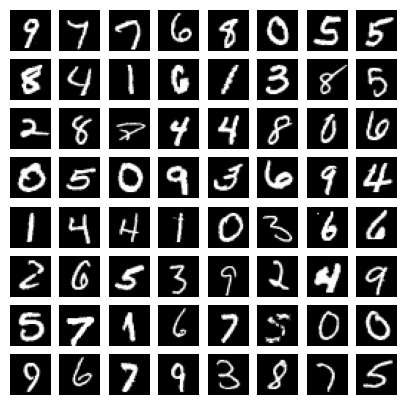

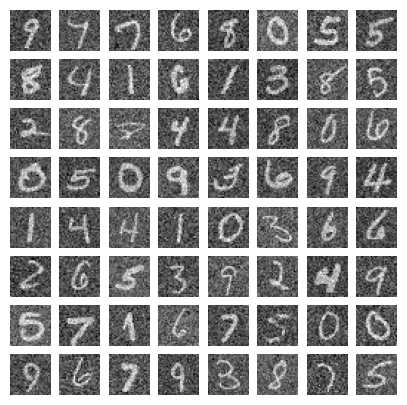

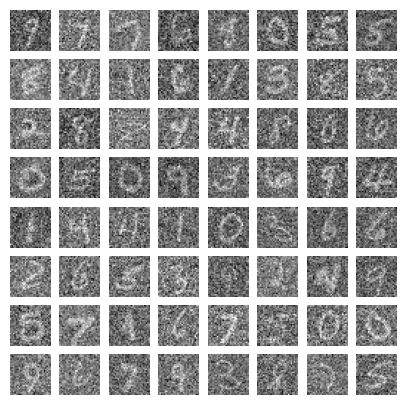

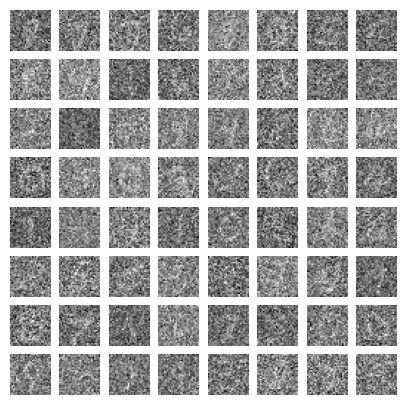

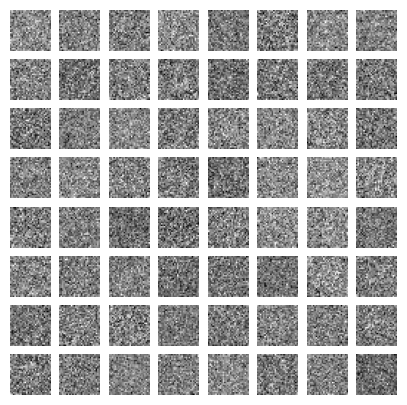

In [ ]:
show_forward(ddpm, loader, device)

### Training the network $ϵ_{\theta}(x_t, t)$

In [ ]:
def training_loop(ddpm, loader, n_epochs, optim, device, display=True, store_path="ddpm_model.pt"):
    mse = nn.MSELoss()
    best_loss = float("inf")
    n_steps = ddpm.n_steps

    for epoch in tqdm(range(n_epochs), desc=f"Training progress", colour="#00ff00"):
        epoch_loss = 0.0
        for step, batch in enumerate(tqdm(loader, leave=False, desc=f"Epoch {epoch + 1}/{n_epochs}", colour="#005500")):
            # Loading data
            x0 = batch[0].to(device)
            n = len(x0)
            # Picking some noise for each of the images in the batch, a timestep and the respective alpha_bars
            eta = torch.randn_like(x0).to(device)
            t = torch.randint(0, n_steps, (n,)).to(device)
            # Computing the noisy image based on x0 and the time-step (forward process)
            noisy_imgs = ddpm(x0, t, eta)

            # Getting model estimation of noise based on the images and the time-step
            eta_theta = ddpm.backward(noisy_imgs, t.reshape(n, -1))

            # Optimizing the MSE between the noise plugged and the predicted noise
            loss = mse(eta_theta, eta)
            optim.zero_grad()
            loss.backward()
            optim.step()

            epoch_loss += loss.item() * len(x0) / len(loader.dataset)

        # Display images generated at this epoch
        if display:
            show_images(generate_new_images(ddpm, device=device), f"Images generated at epoch {epoch + 1}")

        log_string = f"Loss at epoch {epoch + 1}: {epoch_loss:.3f}"

        # Storing the model
        if best_loss > epoch_loss:
            best_loss = epoch_loss
            torch.save(ddpm.state_dict(), store_path)
            log_string += " --> Best model ever (stored)"

        print(log_string)
    return ddpm

In [ ]:
optim = Adam(ddpm.parameters(), lr)

In [ ]:
print(n_steps)
print(batch_size)
print(n_epochs)
print(lr)

300
64
50
0.0003


In [ ]:
import time
start = time.time()
training_loop(ddpm, loader, n_epochs, optim, device, False)
end = time.time()
train_time = end - start

Training progress:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 1: 0.230 --> Best model ever (stored)


Epoch 2/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 2: 0.089 --> Best model ever (stored)


Epoch 3/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 3: 0.078 --> Best model ever (stored)


Epoch 4/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 4: 0.072 --> Best model ever (stored)


Epoch 5/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 5: 0.068 --> Best model ever (stored)


Epoch 6/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 6: 0.065 --> Best model ever (stored)


Epoch 7/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 7: 0.063 --> Best model ever (stored)


Epoch 8/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 8: 0.061 --> Best model ever (stored)


Epoch 9/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 9: 0.060 --> Best model ever (stored)


Epoch 10/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 10: 0.059 --> Best model ever (stored)


Epoch 11/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 11: 0.058 --> Best model ever (stored)


Epoch 12/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 12: 0.056 --> Best model ever (stored)


Epoch 13/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 13: 0.056 --> Best model ever (stored)


Epoch 14/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 14: 0.055 --> Best model ever (stored)


Epoch 15/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 15: 0.055 --> Best model ever (stored)


Epoch 16/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 16: 0.054 --> Best model ever (stored)


Epoch 17/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 17: 0.053 --> Best model ever (stored)


Epoch 18/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 18: 0.052 --> Best model ever (stored)


Epoch 19/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 19: 0.052


Epoch 20/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 20: 0.052 --> Best model ever (stored)


Epoch 21/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 21: 0.052 --> Best model ever (stored)


Epoch 22/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 22: 0.051 --> Best model ever (stored)


Epoch 23/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 23: 0.051 --> Best model ever (stored)


Epoch 24/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 24: 0.051 --> Best model ever (stored)


Epoch 25/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 25: 0.050 --> Best model ever (stored)


Epoch 26/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 26: 0.050 --> Best model ever (stored)


Epoch 27/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 27: 0.050 --> Best model ever (stored)


Epoch 28/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 28: 0.049 --> Best model ever (stored)


Epoch 29/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 29: 0.049 --> Best model ever (stored)


Epoch 30/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 30: 0.049 --> Best model ever (stored)


Epoch 31/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 31: 0.049


Epoch 32/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 32: 0.049 --> Best model ever (stored)


Epoch 33/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 33: 0.049 --> Best model ever (stored)


Epoch 34/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 34: 0.049


Epoch 35/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 35: 0.048 --> Best model ever (stored)


Epoch 36/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 36: 0.048 --> Best model ever (stored)


Epoch 37/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 37: 0.048 --> Best model ever (stored)


Epoch 38/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 38: 0.048 --> Best model ever (stored)


Epoch 39/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 39: 0.048 --> Best model ever (stored)


Epoch 40/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 40: 0.048


Epoch 41/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 41: 0.048


Epoch 42/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 42: 0.048 --> Best model ever (stored)


Epoch 43/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 43: 0.047 --> Best model ever (stored)


Epoch 44/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 44: 0.047 --> Best model ever (stored)


Epoch 45/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 45: 0.048


Epoch 46/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 46: 0.047 --> Best model ever (stored)


Epoch 47/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 47: 0.047 --> Best model ever (stored)


Epoch 48/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 48: 0.047 --> Best model ever (stored)


Epoch 49/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 49: 0.047 --> Best model ever (stored)


Epoch 50/50:   0%|          | 0/938 [00:00<?, ?it/s]

Loss at epoch 50: 0.047 --> Best model ever (stored)


In [ ]:
print(train_time, " seconds")

1429.336894750595  seconds


### Generating images

In [ ]:
inference_exe_time = []

In [ ]:
generated_images = np.array([])

In [ ]:
print(generated_images.shape)
print(type(generated_images))
print(len(dataset))

(16, 826, 28, 28)
<class 'numpy.ndarray'>
60000


In [ ]:
# fig = plt.figure(figsize = (2, 2))
# plt.imshow(generated_images[10][10])
# plt.show()
# plt.close(fig)

Execution time for  50  epochs and  64  batch sizes:  2.0028882026672363


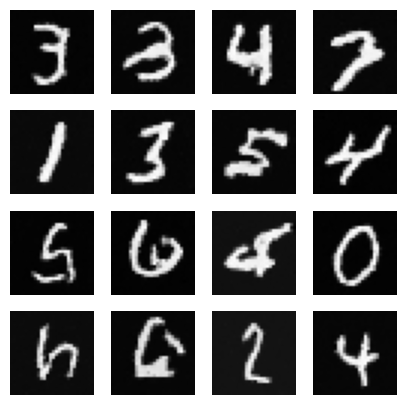

In [ ]:
inference_step(index = 1, show = True, save = False)

Execution time for  50  epochs and  64  batch sizes:  1.869852066040039


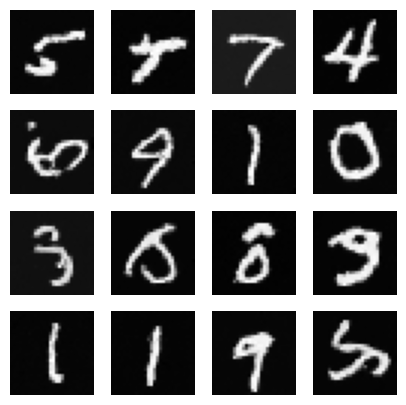

In [ ]:
inference_step(index = 2, show = True, save = False)

Execution time for  50  epochs and  64  batch sizes:  1.907106637954712


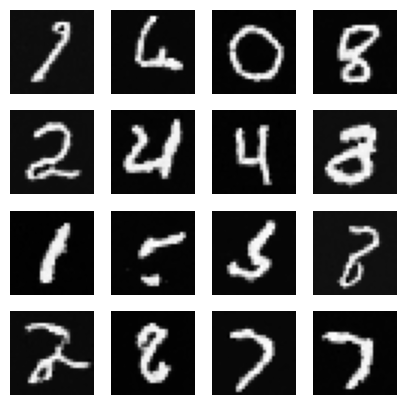

In [ ]:
inference_step(index = 3, show = True, save = False)

Execution time for  50  epochs and  64  batch sizes:  1.888646125793457


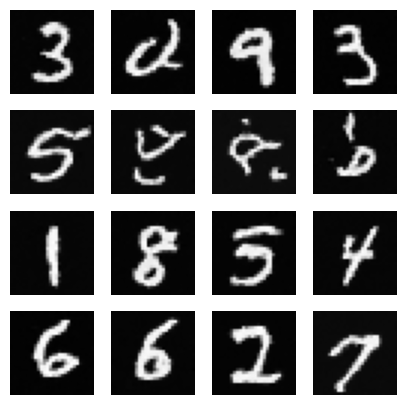

In [ ]:
inference_step(index = 4, show = True, save = False)

Execution time for  50  epochs and  64  batch sizes:  1.9662389755249023


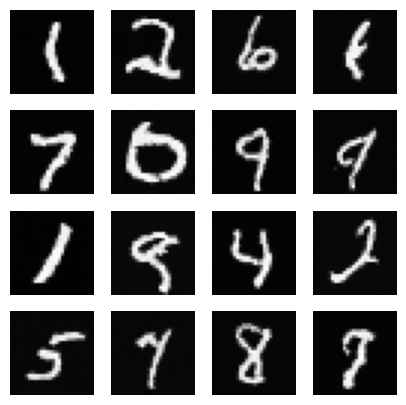

In [ ]:
inference_step(index = 5, show = True, save = False)

In [ ]:
upperbound = int(3300/num_samples_generate)+1
print(upperbound)

207


In [ ]:
# Time consuming!
for i in range(6, upperbound):
    inference_step(index = i, show = False, save = False)

In [ ]:
upperbound_2 = int(10000/num_samples_generate)+1
print(upperbound_2)

626


In [ ]:
# Time consuming!!
for j in range(6, upperbound_2):
    inference_step(index = j, show = False, save = False)

### FID score (pre-built)

In [ ]:
gen_images = np.array([])
length = len(generated_images[0][0])

In [ ]:
print(generated_images.shape)
print(gen_images.shape)
print(length)

(16, 826, 28, 28)
(0,)
28


In [ ]:
for i in range(len(generated_images)):
    for j in range(len(generated_images[0])):
        reshaped = generated_images[i][j].reshape(1, length, length, 1)
        # print(reshaped.shape)
        if len(gen_images)==0:
            gen_images = reshaped
        else:
            gen_images = np.append(gen_images, reshaped, axis = 0)
        # print(gen_images.shape)

In [ ]:
train_set = dataset.data.numpy()
train_set = train_set.reshape(len(train_set), 28, 28, 1)
print(train_set.shape)
print(gen_images.shape)

(60000, 28, 28, 1)


In [ ]:
train_labels = dataset.targets.data.numpy()
print(train_labels.shape)

(60000,)


In [ ]:
import gc

gc.collect()

62920

In [ ]:
from fid import FID_measure
import random

In [ ]:
fid = FID_measure(gen_images_ = gen_images, train_set_ = train_set, labels_ = train_labels)
train_set_shrinked, train_set_shrinked_labels = fid.sample_uniformly()

In [ ]:
score = fid.calculate_fid()
print('FID score: %.3f' % score)

### Calculating Mean and Variance of Distributions

In [ ]:
def calc_mu_and_sigma(dataset):
    # The returned sigma is the covariance matrix and mu is the mean
    flatten_images = []

    for i in range(len(dataset)):
        vectorize = np.array(list(chain.from_iterable(dataset[i])))
        flatten_images.append(vectorize)

    flatten_images = np.array(flatten_images)
    print("Flatten images: ", flatten_images.shape)
    mu = flatten_images.mean(axis = 0)
    print("Mu: ", mu.shape)
    sigma = np.dot(flatten_images[0], flatten_images[0].T)

    print("Sigma: ", sigma.shape)

    for i in range(1, len(flatten_images)):
        Ui = np.dot(flatten_images[i], flatten_images[i].T)
        sigma += Ui

    mu_mu_T = np.dot(mu, mu.T)
    sigma = sigma / len(dataset)
    sigma = sigma - mu_mu_T

    return mu, sigma, flatten_images

In [ ]:
mu_train, sigma_train, vectorized_train = calc_mu_and_sigma(train_set)

Flatten images:  (60000, 784, 1)
Mu:  (784, 1)
Sigma:  (784, 784)


In [ ]:
mu_gen, sigma_gen, vectorized_gen = calc_mu_and_sigma(gen_images)

Flatten images:  (13216, 784, 1)
Mu:  (784, 1)
Sigma:  (784, 784)


In [ ]:
gc.collect()

3343

### Inference time (average)

Mean inference time:  1.9131


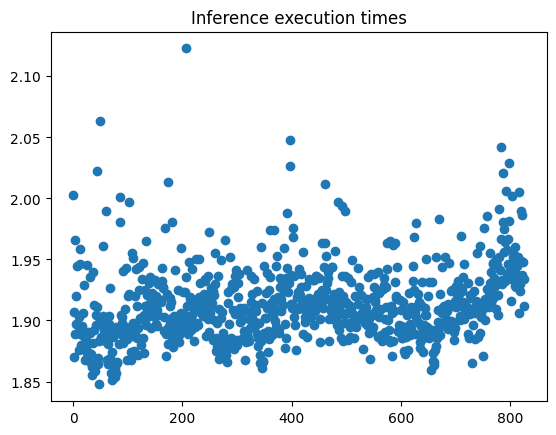

In [ ]:
plot_inference_exe_time(inference_exe_time)
print("Mean inference time: ", round(sum(inference_exe_time)/len(inference_exe_time), 4))

### CNN for Predicting Generated Images

In [ ]:
from keras.models import load_model
cnn = load_model('CNN.h5')

In [ ]:
preds_gen = cnn.predict(gen_images)
pred_labels_gen = np.argmax(preds_gen, axis=1)

413/413 [==============================] - 2s 2ms/step


In [ ]:
unique_elements, counts = np.unique(pred_labels_gen, return_counts=True)
frequency = dict(zip(unique_elements, counts))
print("Frequency of Elements: ")
print(frequency)

Frequency of Elements: 
{0: 1326, 1: 1581, 2: 1451, 3: 1349, 4: 1369, 5: 1491, 6: 1641, 7: 1055, 8: 1054, 9: 899}


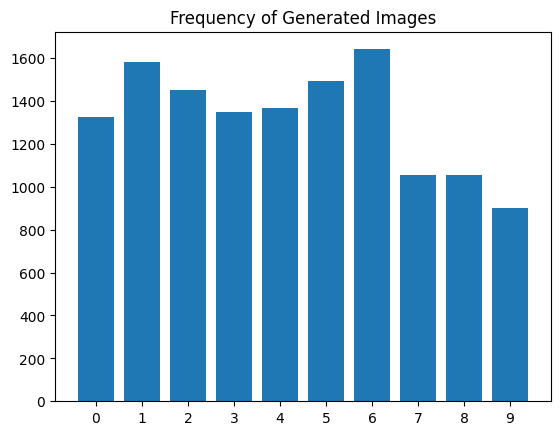

In [ ]:
plt.bar(unique_elements, counts)
plt.xticks(np.arange(10))
plt.title('Frequency of Generated Images')
plt.show()

### Viewing Dimension-Reduced Samples

In [ ]:
print(vectorized_gen.shape)
print(vectorized_train.shape)

(13216, 784, 1)
(60000, 784, 1)


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
def scatter(first_axis, second_axis, labels, title):
    plt.figure(figsize=(10, 8))
    unique_classes = set(labels)
    plt.title(title)
    colors = ["red", "green", "blue", "yellow", "pink", "black", "orange", "purple", "cyan", "magenta"]
    for i, class_label in enumerate(unique_classes):
        class_indices = [j for j, c in enumerate(labels) if c == class_label]
        plt.scatter([first_axis[idx] for idx in class_indices],
                    [second_axis[idx] for idx in class_indices],
                    color=colors[i % len(colors)],
                    label=f'Class {class_label}')

    plt.legend()
    plt.show()

def map_diversity(data, variance_PCA):
    if data.ndim == 3:
        data = data.squeeze()
    pca = PCA(n_components = variance_PCA)
    reduced_vectors_pca = pca.fit_transform(data)
    # print(pca.n_components_) # If interested
    tsne = TSNE(n_components=2)
    reduced_vectors_tsne = tsne.fit_transform(reduced_vectors_pca)
    return reduced_vectors_tsne

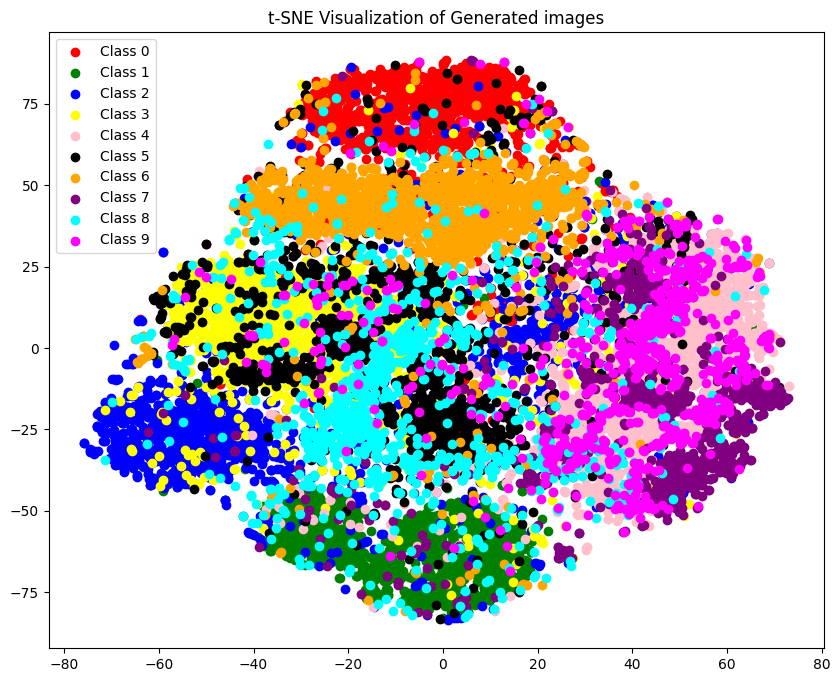

In [ ]:
reduced_dimension_gen = map_diversity(data = vectorized_gen, variance_PCA = 0.85)
scatter(reduced_dimension_gen[:, 0], reduced_dimension_gen[:, 1], pred_labels_gen, 't-SNE Visualization of Generated images')

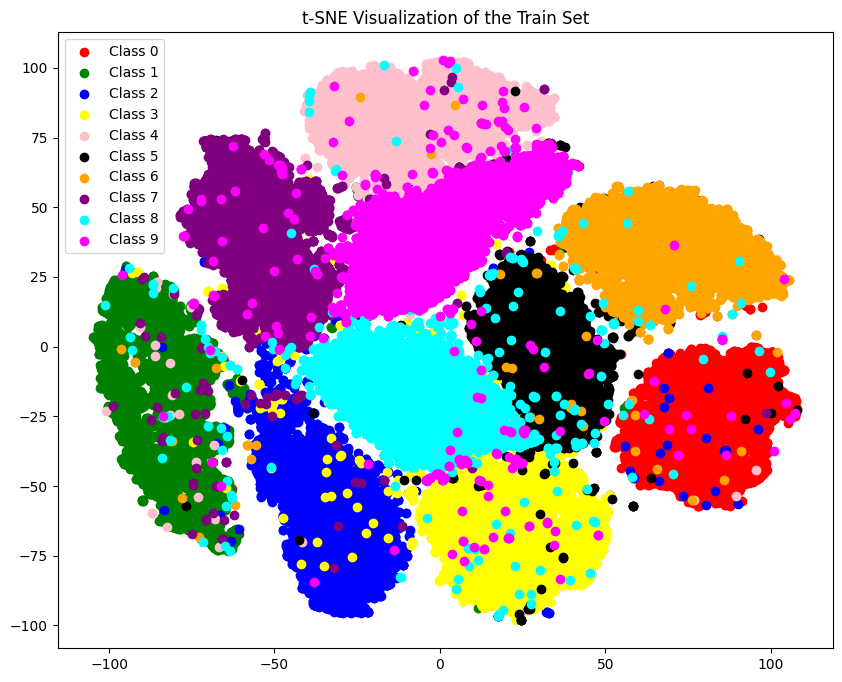

In [ ]:
reduced_dimension_train = map_diversity(data = vectorized_train, variance_PCA = 0.85)
scatter(reduced_dimension_train[:, 0], reduced_dimension_train[:, 1], train_labels, 't-SNE Visualization of the Train Set')

### Precision, Recall, Density, Coverage measures

In [ ]:
import locale
print(locale.getpreferredencoding())

ANSI_X3.4-1968


In [ ]:
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!pip3 install prdc

from prdc import compute_prdc

In [ ]:
_, _, vectorized_train_shrinked = calc_mu_and_sigma(train_set_shrinked)
reduced_dimension_train_shrinked = map_diversity(data = vectorized_train_shrinked, variance_PCA = 0.85)

In [ ]:
for j in np.asarray([5, 10, 6, 3, 2, 1]):
    print(j, "-Nearest Neighbors")
    metrics = compute_prdc(real_features = reduced_dimension_train_shrinked,
                          fake_features = reduced_dimension_gen,
                          nearest_k=j)

    print(metrics)
    print("\n----------------------------------\n")

5 -Nearest Neighbors
Num real: 10000 Num fake: 13216
{'precision': 0.8336864406779662, 'recall': 0.9022, 'density': 0.7222306295399517, 'coverage': 0.7654}

----------------------------------

10 -Nearest Neighbors
Num real: 10000 Num fake: 13216
{'precision': 0.8914194915254238, 'recall': 0.9199, 'density': 0.729850181598063, 'coverage': 0.8571}

----------------------------------

6 -Nearest Neighbors
Num real: 10000 Num fake: 13216
{'precision': 0.8529812348668281, 'recall': 0.9092, 'density': 0.7297467715899919, 'coverage': 0.7997}

----------------------------------

3 -Nearest Neighbors
Num real: 10000 Num fake: 13216
{'precision': 0.7455357142857143, 'recall': 0.8381, 'density': 0.6784200968523002, 'coverage': 0.6164}

----------------------------------

2 -Nearest Neighbors
Num real: 10000 Num fake: 13216
{'precision': 0.6161470944309927, 'recall': 0.728, 'density': 0.5886425544794189, 'coverage': 0.4592}

----------------------------------

1 -Nearest Neighbors
Num real: 10000